# Model Training and Evaluation

In [462]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn import BCELoss
import torch.optim as optim
from torch.utils.data  import TensorDataset, DataLoader
import torchmetrics

import pickle
import os
import itertools


## Base Models

The first set of implemented models will be based on the simplest preprocessing methods without feature engineering. These models will act as a benchmark for all subsequent attempts. The set will include a K-Neighbors Classifier, a Decision Tree, a Gradient Boosting, a Random Forest, a Linear Discriminant Analysis, and a Logistic Regression model. The models will be compared, and a feature importance plot will be plotted using the best-performing model. 

### Base Models with Iteratively Imputed Data

The models will first be implemented with the data imputed with the Iterative Imputer. The dataset is loaded below.

In [2]:
train_imputed_iterative = pd.read_pickle('../Data/Preprocessed/train_imputed_iterative.pkl')

In [3]:
# Splitting the data into features and responses:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The models to be implemented are first defined inside a dictionary. A results list is instantiated to save the model score results. Since this is a classification problem, the metrics of interest will be *accuracy*, *precision* and *recall*. *Precision* can be viewed as the accuracy of the positive predictions; it can be calculated as follows:

$$precision = \frac{TP}{TP + FP},$$

where $TP$ is the number of true positives, and $FP$ is the number of false positives. This metric is usually reported alongside *recall*, also called *sensitivity* or the *true positive rate* (TPR). *Recall* is the ratio of positive instances that are correctly classified. *Recall* can be calculated as follows:

$$recall = \frac{TP}{TP + FN},$$

where $TP$ is the number of true positives and $FN$, the number of false negatives [(Aurelian Géron, 2023)](#ref-Geron2023).


To avoid overfitting, K-fold cross-validation (with ten splits) is used. K=10 was chosen as a generally acceptable number for this method. The results from the cross-validation are stored in a pickle file for further use. 

In [4]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')


The results are now printed, and accuracy plots are presented for comparison. 

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943294
                             Precision  0.951660
                             Recall     0.948087
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962754
                             Precision  0.955711
                             Recall     0.979645


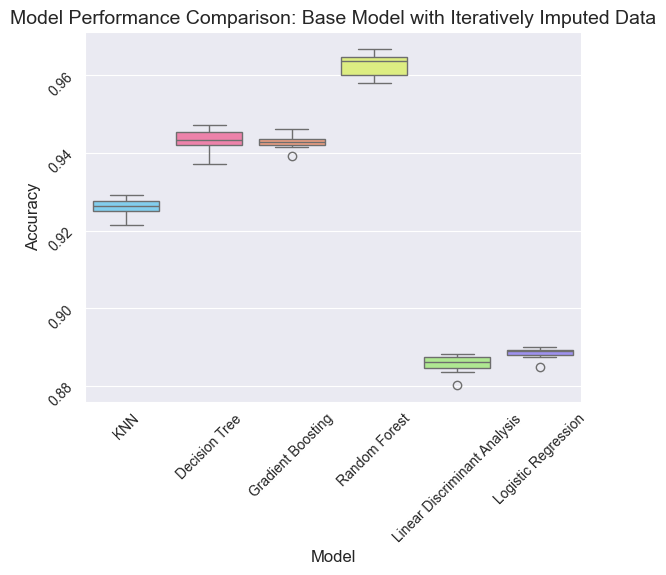

In [5]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customising the plots:
ax.set_title('Model Performance Comparison: Base Model with Iteratively Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

The plot above and the comparison data frame for the results clearly show that the Random Forrest model outperformed the others. It has achieved an accuracy of 0.9627, a precision of 0.9557 and a recall of 0.9796. These results are surprisingly high for a base model.

### Base Model with KNN Imputer 

The KNN-imputed data will now be imported for the next set of model comparisons. The same steps will be undertaken as in the previous implementation.

In [6]:
train_imputed_knn = pd.read_pickle('../Data/Preprocessed/train_imputed_knn.pkl')

In [7]:
# Splitting the data into features and responses:
X = train_imputed_knn.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_knn['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.944574
                             Precision  0.934158
                             Recall     0.938232
Gradient Boosting            Accuracy   0.942995
                             Precision  0.947188
                             Recall     0.919768
KNN                          Accuracy   0.924247
                             Precision  0.942093
                             Recall     0.879262
Linear Discriminant Analysis Accuracy   0.884220
                             Precision  0.865326
                             Recall     0.867871
Logistic Regression          Accuracy   0.887175
                             Precision  0.872630
                             Recall     0.866017
Random Forest                Accuracy   0.963822
                             Precision  0.974326
                             Recall     0.941348


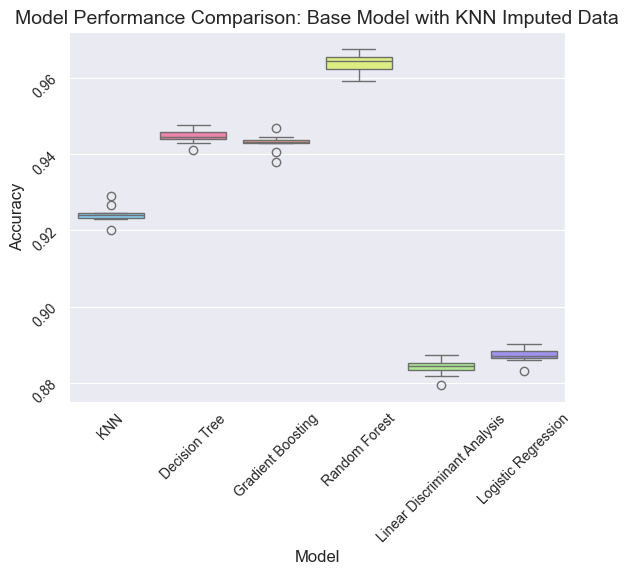

In [9]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customising the plots:
ax.set_title('Model Performance Comparison: Base Model with KNN Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Results with the KNN-imputed data are slightly better than those obtained with the Iterative Imputer. The Random Forrest algorithm obtains an accuracy score of approximately 0.9638, a precision of 0.9743, and a recall of 0.9413.

### Base Model with DropNa and Mode Imputation

Here, the data with the thrid imputation method will be imported. A reminder: entries with NaNs were dropped only for those features where the number of NaNs was less than the established threshold of 5% (of the data size). For all other features, the mode was used to impute the missing values. This imputation method assumes that the 'Non-Applicable' categories are irrelevant for response predictions.

In [10]:
# Importing the preprocessed data:
train_preprocessed_dropna_mode = pd.read_pickle('../Data/Preprocessed/train_preprocessed_dropna_mode.pkl')

In [11]:
# Splitting the data into features and responses:
X = train_preprocessed_dropna_mode.drop(columns = 'Satisfaction', axis = 1)
y = train_preprocessed_dropna_mode['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945630
                             Precision  0.954313
                             Recall     0.951566
Gradient Boosting            Accuracy   0.944356
                             Precision  0.943362
                             Recall     0.961529
KNN                          Accuracy   0.937811
                             Precision  0.931738
                             Recall     0.963055
Linear Discriminant Analysis Accuracy   0.894912
                             Precision  0.912730
                             Recall     0.904835
Logistic Regression          Accuracy   0.898806
                             Precision  0.911469
                             Recall     0.913809
Random Forest                Accuracy   0.963919
                             Precision  0.957720
                             Recall     0.980927


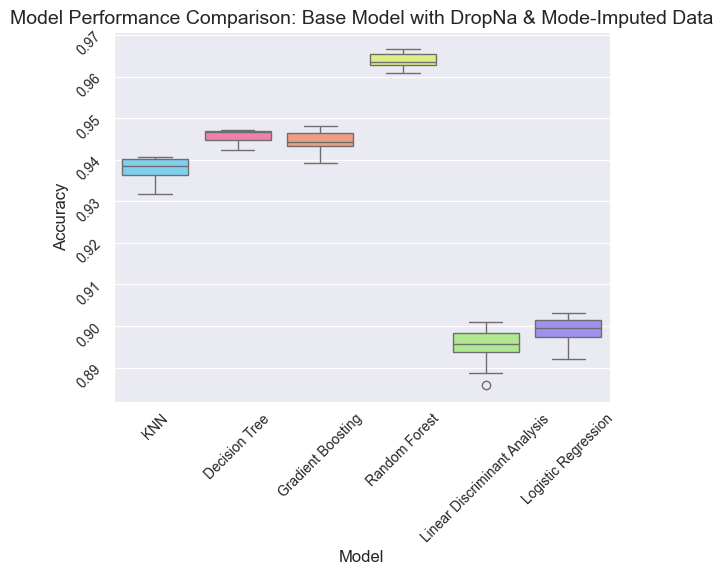

In [551]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customising the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode-Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Again, the plot looks similar to the previous two. The Random Forrest results are slightly better than those of KNN. This model reached an accuracy of 0.9639, a precision of 0.9577, and a recall of 0.9809. This suggests that dropping the NaN entries has slightly helped the model performance. 

### Base Model with Non-Applicable Category

The last model comparison will be performed using the data set where the 'Non-Applicable' entries were given a separate category in the data. The missing values for the 'Arrival Delay in Minutes' feature were computed using the Iterative Imputer, with an `initial_strategy` set to the 'mean'. 

In [14]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [15]:
# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945546
                             Precision  0.953385
                             Recall     0.950359
Gradient Boosting            Accuracy   0.943987
                             Precision  0.941742
                             Recall     0.960561
KNN                          Accuracy   0.928001
                             Precision  0.914205
                             Recall     0.963335
Linear Discriminant Analysis Accuracy   0.872363
                             Precision  0.877534
                             Recall     0.900406
Logistic Regression          Accuracy   0.875616
                             Precision  0.878800
                             Recall     0.905350
Random Forest                Accuracy   0.965179
                             Precision  0.958047
                             Recall     0.981519


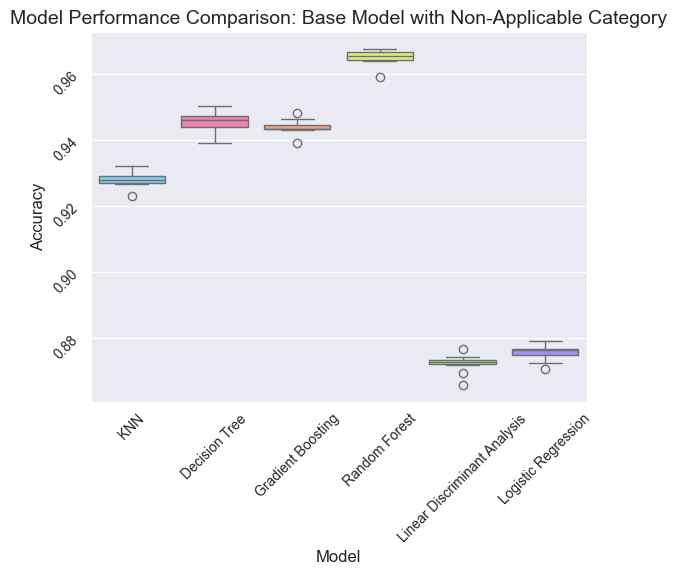

In [17]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Non-Applicable Category', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The comparison plot looks similar to all the other attempts. The Random Forest algorithm has achieved an accuracy of 0.9652, a precision of 0.9580, and a recall of 0.9815, slightly better than the results with the other data sets.

## Feature Engineering

Two attempts will be made with feature engineering before proceeding to hyper-parameter tuning of the best-performing model. The data for these models has been preprocessed in the `feature_engineering` notebook. 

### Feature Selection Model

In the first implementation, a dataset that includes only a subset of the data will be used. Eliminating features that do not impact the response could improve the model's predictive efficiency and accuracy. 

In [18]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [19]:
# Splitting the data into features and responses:
X = train_fs.drop(columns = 'Satisfaction', axis = 1)
y = train_fs['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Model_fs/results_fs_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.942081
                             Precision  0.950163
                             Recall     0.947460
Gradient Boosting            Accuracy   0.940397
                             Precision  0.937040
                             Recall     0.959252
KNN                          Accuracy   0.930657
                             Precision  0.915842
                             Recall     0.966426
Linear Discriminant Analysis Accuracy   0.870140
                             Precision  0.875545
                             Recall     0.898547
Logistic Regression          Accuracy   0.872825
                             Precision  0.876719
                             Recall     0.902455
Random Forest                Accuracy   0.960002
                             Precision  0.953104
                             Recall     0.977502


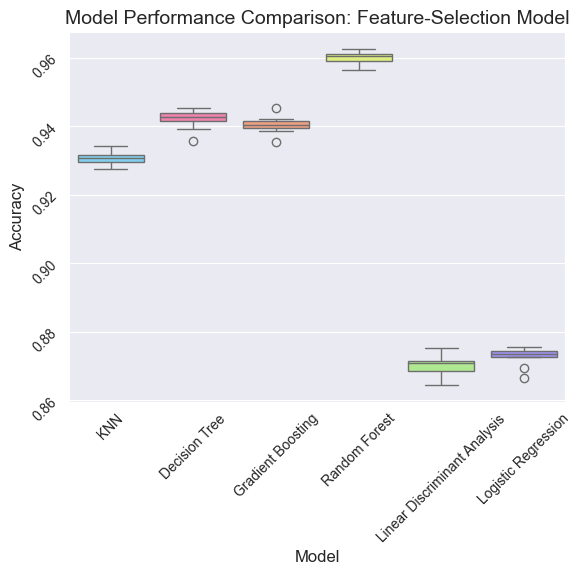

In [552]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fs/results_fs_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customising the plots:
ax.set_title('Model Performance Comparison: Feature-Selection Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The plots and results seem to be worse when feature selection is performed. It seems like too much information is lost when features are excluded.

### Feature Extraction Model

The same models will be tested with two extra aggregated features, `Overall Satisfaction Score` and `Premium Service`. The relevant dataset is imported.

In [22]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [23]:
# Splitting the data into features and responses:
X = train_oss.drop(columns = 'Satisfaction', axis = 1)
y = train_oss['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
results = []

# Defining the scoring metrics:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)}

# Performing the cross-validation:
for name, model in models.items():
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    results.append({
        'Model': name,
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision'],
        'Recall': cv_results['test_recall']
    })

# Creating a long-format data frame:
rows = []

for model_dict in results:
    model_name = model_dict.pop('Model')
    for metric_name, metric_values in model_dict.items():
        for value in metric_values:
            rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

results_long = pd.DataFrame(rows)

# Saving results:
results_long.to_pickle('../Models/Model_fe/results_fe_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945565
                             Precision  0.953791
                             Recall     0.949953
Gradient Boosting            Accuracy   0.944073
                             Precision  0.941707
                             Recall     0.960767
KNN                          Accuracy   0.926634
                             Precision  0.912392
                             Recall     0.962999
Linear Discriminant Analysis Accuracy   0.871160
                             Precision  0.876867
                             Recall     0.898839
Logistic Regression          Accuracy   0.875106
                             Precision  0.878668
                             Recall     0.904479
Random Forest                Accuracy   0.964429
                             Precision  0.957307
                             Recall     0.980958


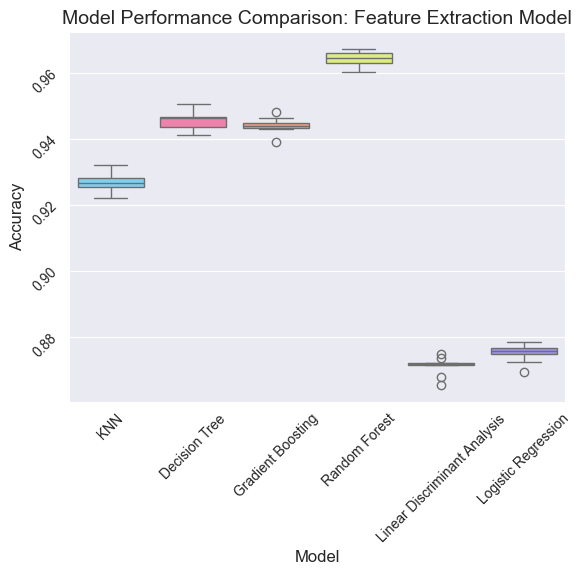

In [25]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fe/results_fe_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Extraction Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

This model has also achieved relatively good results. The Random Forest algorithm has achieved an accuracy score of 0.9644, a precision of 0.9573 and a recall of 0.9809. 

### Feature Importance Plot

The best-performing model has been the 'Base Model with a Non-Applicable Category'. This model will be used to plot feature importance, that is, the most important features driving customer satisfaction outcomes.

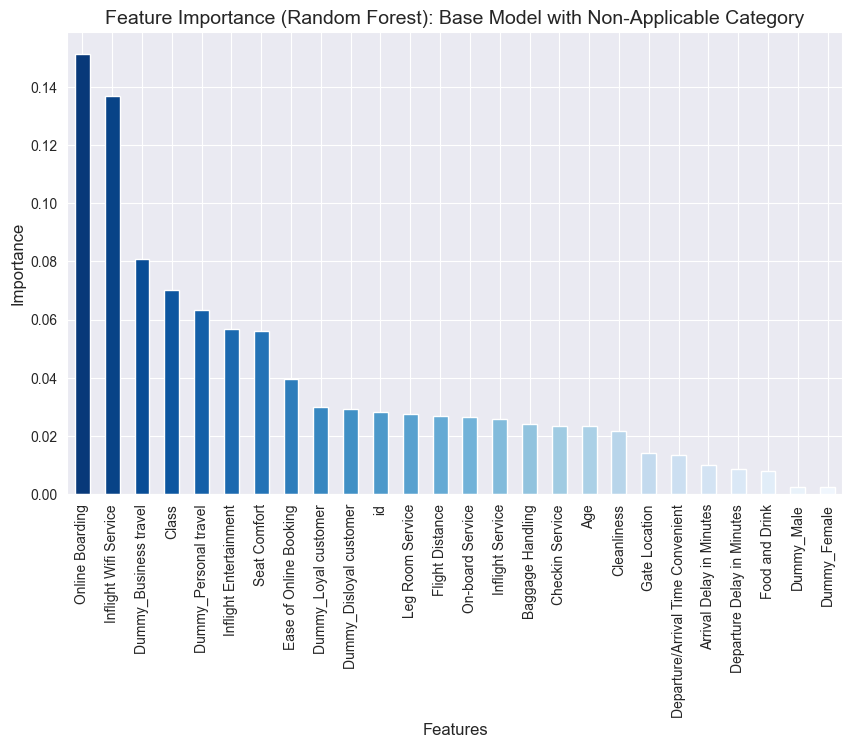

In [26]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting the model:
rf = RandomForestClassifier()
model_rf = rf.fit(X_scaled, y)
model_pkl_file = '../Models/Imputation_Model_4/model_rf.pkl'
with open(model_pkl_file, 'wb') as file:  
         pickle.dump(model_rf, file)

with open(model_pkl_file, 'rb') as file:
        model_rf = pickle.load(file)

# Plotting the feature importance:
importance = pd.Series(model_rf.feature_importances_, index=X.columns)
colors = list(reversed(sns.color_palette("Blues", len(importance))))
ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
# Customising the plot:
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Importance', fontsize=12)
ax.set_title('Feature Importance (Random Forest): Base Model with Non-Applicable Category', fontsize=14)
ax.tick_params(axis='both', labelsize=10)
plt.show()


The plot shows that the main features driving customer satisfaction are `Online Boarding`, `Inflight Wifi Service` and whether the travel was for Business purposes(`Dummy_Business travel`). Unsurprisingly, the sex of the passenger has the least impact on customer satisfaction.

## Deep Neural Network

Improving the model's performance substantially through simple feature engineering was impossible. The next model to be implemented will be a deep neural network using PyTorch. These machine-learning models can perform feature engineering with raw data. This neural network will use the data with the 'Non-Applicable' category since it provides the best results using standard machine learning algorithms.

In [66]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

non_applicable_imputed.shape

(103904, 27)

Below are all the necessary procedures for using the data in a neural network:

In [197]:
# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encoding the target:
encoder = LabelEncoder()
encoder.fit(y)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Creating the train_dataset and the trainloader:
train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train_encoded).reshape(-1, 1).float())
trainloader = DataLoader(train_dataset, batch_size = 1000, shuffle = True)

# Creating the test_dataset and the validation loader:
test_dataset = TensorDataset(torch.tensor(X_test_scaled).float(), torch.tensor(y_test_encoded).reshape(-1, 1).float())
testloader = DataLoader(test_dataset, batch_size = 1000, shuffle = True)

The model, criteria, optimiser and metrics are defined before the training and validation loop is set up. 

In [29]:
# Defining the model:
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary')

### Overfitting the Training Data to Validate the Model

A small training set sample is overfitted to ensure the model can solve the underlying classification task. The model achieves an accuracy of 1 and a loss close to 0. This simple task is performed below, with the metrics of interest also printed.

Accuracy: 1.0
Loss: 0.005110020749270916


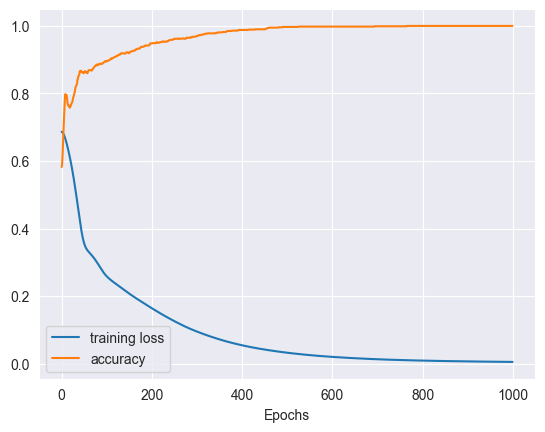

In [30]:
# Setting the training loss to zero:
training_loss = []
accuracy_store = []


# Taking one batch from the trainloader:
feature, target = next(iter(trainloader))

# Performing the training loop on the batch:
for i in range(int(1000)):
    
    # Runing the forward pass:
    prediction = model(feature)
    # Calculating accuracy over batch:
    accuracy = metric(prediction, target)
    accuracy_store.append(accuracy.item())
    # Calculating the loss:
    loss = criterion(prediction, target)
    # Storing the loss value for plotting:
    training_loss.append(loss.item())
    # Zeroing the gradient:
    optimizer.zero_grad()
    # Getting the gradients:
    loss.backward()
    # Updating the parameters:
    optimizer.step()

print('Accuracy:', accuracy.item())
print('Loss:', loss.item())

# Resetting the metrics:
metric.reset() 
 
plt.plot(training_loss)
plt.plot(accuracy_store)
plt.xlabel('Epochs')
plt.legend(['training loss', 'accuracy'])
plt.show()

The graph shows that the model can overfit the small training set and achieve an accuracy of 1 and a loss close to 0.

### Reducing the Overfitting

It is now possible to focus on reducing the overfitting and achieving the best possible validation score (on the test dataset). The same model used to overfit a small sample of the training set is now used on the whole training set. 

In [75]:
# Defining the model:
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)



A function is created for 100 epochs, which will be used repeatedly to test different model parameters. This iterative process aims to achieve the highest accuracy and lowest loss on the validation set.

Each epoch's loss and accuracy (on training and test sets) are saved for potential plotting. The model with the best accuracy score on the validation set is also saved for potential use on the final test set. The train and test loss for every ten epochs show the model’s learning process and performance.

In [255]:
def run_100_epochs(number = 1):
    # Setting the number of epochs:
    epochs = 100

    # Instantiating metric results for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []

    # Instantiation variables to track the best model based on validation accuracy:
    best_val_accuracy = 0.0 
    best_model_state = None

    # Building the epoch loop:
    for epoch in range(epochs):
        
        # Setting the model to training mode:
        model.train()

        # Setting the training loss and accuracy to 0:
        training_loss = 0
        training_accuracy = 0

        # Building a loop for the train set data loader:
        for i, data in enumerate(trainloader, 0):
            
            # Starting a training loop:
            model.train()
            # Setting the gradients to zero:
            optimizer.zero_grad()
            # Getting the feature and target from the data loader:
            feature, target = data
            # Runing the forward pass:
            prediction = model(feature)
            # Calculating the loss:
            loss = criterion(prediction, target)
            # Storing the loss values for plotting:
            training_loss += loss.item()
            # Calculating accuracy over the batch:
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            # Getting the gradients:
            loss.backward()
            # Updating the parameters:
            optimizer.step()

        # Storing the results of interest for plotting:
        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        # Setting the validation loss and accuracy to 0:
        validation_loss = 0
        validation_accuracy = 0

        # Setting the model to evaluation mode:
        model.eval()

        # Building a loop for the test set data loader:
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):

                # Starting an evaluation loop:
                model.eval()
                # Getting the feature and target from the data loader:
                feature, target = data
                # Running the forward pass:
                prediction = model(feature)
                # Calculating the loss:
                loss = criterion(prediction, target)
                # Calculating accuracy over batch:
                accuracy = metric(prediction, target)
                validation_accuracy += accuracy.item()
                validation_loss += loss.item()

        # Storing the results of interest for plotting:
        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        # Check if this is the best model based on validation accuracy (or loss):
        if epoch_test_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_test_accuracy
            best_model_state = model.state_dict()

        # Setting the model back to training mode:
        model.train()

        # Printing out what's happening every ten epochs:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    # Saving the best model based on validation accuracy:
    if best_model_state:
        torch.save(best_model_state, ("../Models/Neural_Nets/best_model_{}.pth").format(number))
        print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.5f}")

    # Resetting the metrics:
    metric.reset() 

    # Saving the lists using pickle:
    with open(f'../Models/Neural_Nets/training_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_loss_storage, file)
    with open(f'../Models/Neural_Nets/test_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_loss_storage, file)
    with open(f'../Models/Neural_Nets/train_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_accuracy_storage, file)
    with open(f'../Models/Neural_Nets/validation_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_accuracy_storage, file)

    return epoch_train_loss_storage, epoch_test_loss_storage, epoch_train_accuracy_storage, epoch_test_accuracy_storage

The first model will be run with the initial parameters presented above. 

In [77]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs()

Epoch: 0 | Train Loss: 0.48973| Test loss: 0.33320
Epoch: 10 | Train Loss: 0.14496| Test loss: 0.14670
Epoch: 20 | Train Loss: 0.12122| Test loss: 0.12588
Epoch: 30 | Train Loss: 0.10934| Test loss: 0.11490
Epoch: 40 | Train Loss: 0.09917| Test loss: 0.11293
Epoch: 50 | Train Loss: 0.09312| Test loss: 0.10837
Epoch: 60 | Train Loss: 0.08986| Test loss: 0.10702
Epoch: 70 | Train Loss: 0.08686| Test loss: 0.10605
Epoch: 80 | Train Loss: 0.08293| Test loss: 0.10316
Epoch: 90 | Train Loss: 0.08114| Test loss: 0.10593

Best model saved with validation accuracy: 0.95755


The accuracy score achieved with this neural network is not very good, given the accuracy scores achieved with simple machine learning models. Further parameter tuning will be performed to improve the model's performance.

A function will be defined to plot the model loss scores on both the training and validation sets. This function will most likely be used several times throughout the report.

In [78]:
def plot_loss(training_loss, validation_loss):    
    plt.plot(training_loss)
    plt.plot(validation_loss)
    plt.legend(['training loss', 'validation loss'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Loss')
    plt.show()

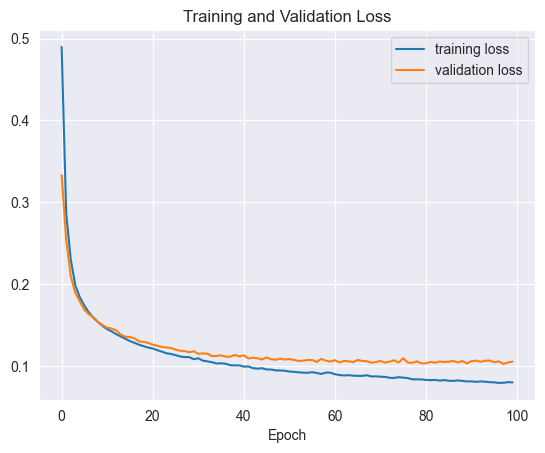

In [80]:
with open(f'../Models/Neural_Nets/training_losses_1.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_1.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The graph shows that the training and validation loss decrease substantially after the first five epochs. Overfitting seems to begin after 17 epochs, where the training loss decreases faster than the validation loss.

A function to plot the accuracy is also defined below. 

In [81]:
def plot_accuracy(training_accuracy, validation_accuracy):
    plt.plot(training_accuracy)
    plt.plot(validation_accuracy)
    plt.legend(['training accuracy', 'validation accuracy'])
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')
    plt.show()


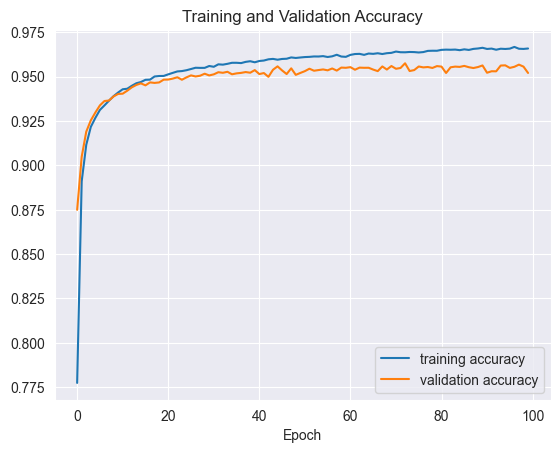

In [83]:
with open(f'../Models/Neural_Nets/train_accuracies_1.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_1.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Again, the accuracy seems to increase exponentially in the first five epochs; the rate of increase then drops dramatically.

A dropout layer is added after the activation function to help with 'regularisation' in the following model. This layer acts differently during training and evaluation. The probability is set to 50%.

In [84]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.95)

In [85]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(2)

Epoch: 0 | Train Loss: 0.50352| Test loss: 0.33411
Epoch: 10 | Train Loss: 0.15524| Test loss: 0.14620
Epoch: 20 | Train Loss: 0.12792| Test loss: 0.12433
Epoch: 30 | Train Loss: 0.11424| Test loss: 0.11466
Epoch: 40 | Train Loss: 0.10519| Test loss: 0.10738
Epoch: 50 | Train Loss: 0.09828| Test loss: 0.10186
Epoch: 60 | Train Loss: 0.09410| Test loss: 0.09908
Epoch: 70 | Train Loss: 0.08996| Test loss: 0.09781
Epoch: 80 | Train Loss: 0.08617| Test loss: 0.09633
Epoch: 90 | Train Loss: 0.08411| Test loss: 0.09579

Best model saved with validation accuracy: 0.95990


This has helped achieve a higher accuracy score while keeping all other parameters constant. Next, weight decay (L2 norm penalization) is added to the optimiser [(Pytorch Contributors, 2023)](ref-pytorch2023). 

In [553]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [87]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(3)

Epoch: 0 | Train Loss: 0.38509| Test loss: 0.24683
Epoch: 10 | Train Loss: 0.10991| Test loss: 0.10935
Epoch: 20 | Train Loss: 0.09216| Test loss: 0.10039
Epoch: 30 | Train Loss: 0.08598| Test loss: 0.09320
Epoch: 40 | Train Loss: 0.08069| Test loss: 0.09372
Epoch: 50 | Train Loss: 0.07780| Test loss: 0.09313
Epoch: 60 | Train Loss: 0.07608| Test loss: 0.09215
Epoch: 70 | Train Loss: 0.07357| Test loss: 0.09283
Epoch: 80 | Train Loss: 0.07283| Test loss: 0.09895
Epoch: 90 | Train Loss: 0.07229| Test loss: 0.09592

Best model saved with validation accuracy: 0.96222


The accuracy score has improved with the addition of this new parameter.

Now, the number of parameters in the first layer of the network will be increased to 200:

In [391]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [392]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(4)

Epoch: 0 | Train Loss: 0.39949| Test loss: 0.25430
Epoch: 10 | Train Loss: 0.13805| Test loss: 0.11483
Epoch: 20 | Train Loss: 0.11550| Test loss: 0.10118
Epoch: 30 | Train Loss: 0.10669| Test loss: 0.09194
Epoch: 40 | Train Loss: 0.09972| Test loss: 0.09028
Epoch: 50 | Train Loss: 0.09654| Test loss: 0.08753
Epoch: 60 | Train Loss: 0.09375| Test loss: 0.08660
Epoch: 70 | Train Loss: 0.09222| Test loss: 0.08455
Epoch: 80 | Train Loss: 0.09265| Test loss: 0.08462
Epoch: 90 | Train Loss: 0.09072| Test loss: 0.08515

Best model saved with validation accuracy: 0.96419


The model's accuracy has improved slightly. The same set of parameters will be increased even further below:

In [90]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [91]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(5)

Epoch: 0 | Train Loss: 0.37908| Test loss: 0.24450
Epoch: 10 | Train Loss: 0.13582| Test loss: 0.11539
Epoch: 20 | Train Loss: 0.11205| Test loss: 0.09764
Epoch: 30 | Train Loss: 0.10298| Test loss: 0.09260
Epoch: 40 | Train Loss: 0.09654| Test loss: 0.08970
Epoch: 50 | Train Loss: 0.09256| Test loss: 0.08722
Epoch: 60 | Train Loss: 0.08956| Test loss: 0.08432
Epoch: 70 | Train Loss: 0.08846| Test loss: 0.08419
Epoch: 80 | Train Loss: 0.08670| Test loss: 0.08378
Epoch: 90 | Train Loss: 0.08672| Test loss: 0.08335

Best model saved with validation accuracy: 0.96454


Up to now, the model's accuracy has increased when the number of parameters is increased. In the next model, the fourth layer's parameters will be increased to 200:

In [92]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [93]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(6)

Epoch: 0 | Train Loss: 0.37414| Test loss: 0.24064
Epoch: 10 | Train Loss: 0.13563| Test loss: 0.11494
Epoch: 20 | Train Loss: 0.11038| Test loss: 0.09922
Epoch: 30 | Train Loss: 0.09964| Test loss: 0.09304
Epoch: 40 | Train Loss: 0.09416| Test loss: 0.08952
Epoch: 50 | Train Loss: 0.09032| Test loss: 0.08713
Epoch: 60 | Train Loss: 0.08804| Test loss: 0.08573
Epoch: 70 | Train Loss: 0.08704| Test loss: 0.08515
Epoch: 80 | Train Loss: 0.08647| Test loss: 0.08266
Epoch: 90 | Train Loss: 0.08411| Test loss: 0.08473

Best model saved with validation accuracy: 0.96486


The model's accuracy score keeps increasing. Now, another set of Linear and ReLU layers is added to the model:

In [94]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [95]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(7)

Epoch: 0 | Train Loss: 0.43667| Test loss: 0.24887
Epoch: 10 | Train Loss: 0.11959| Test loss: 0.10196
Epoch: 20 | Train Loss: 0.09857| Test loss: 0.08958
Epoch: 30 | Train Loss: 0.09111| Test loss: 0.08634
Epoch: 40 | Train Loss: 0.08683| Test loss: 0.08730
Epoch: 50 | Train Loss: 0.08467| Test loss: 0.08385
Epoch: 60 | Train Loss: 0.08284| Test loss: 0.08271
Epoch: 70 | Train Loss: 0.08033| Test loss: 0.08221
Epoch: 80 | Train Loss: 0.08175| Test loss: 0.08201
Epoch: 90 | Train Loss: 0.07976| Test loss: 0.08296

Best model saved with validation accuracy: 0.96594


The accuracy has increased once again. Now, the number of parameters in the newly created layers will also be increased:

In [99]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.95, weight_decay = 1e-4)

In [100]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(8)

Epoch: 0 | Train Loss: 0.42041| Test loss: 0.25444
Epoch: 10 | Train Loss: 0.11829| Test loss: 0.10374
Epoch: 20 | Train Loss: 0.09923| Test loss: 0.09664
Epoch: 30 | Train Loss: 0.09026| Test loss: 0.08702
Epoch: 40 | Train Loss: 0.08595| Test loss: 0.08706
Epoch: 50 | Train Loss: 0.08455| Test loss: 0.08296
Epoch: 60 | Train Loss: 0.08318| Test loss: 0.08286
Epoch: 70 | Train Loss: 0.07985| Test loss: 0.08197
Epoch: 80 | Train Loss: 0.07963| Test loss: 0.08292
Epoch: 90 | Train Loss: 0.07828| Test loss: 0.08071

Best model saved with validation accuracy: 0.96568


The model's accuracy did not improve. The optimiser will be changed to the Adam optimiser.

In [126]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [127]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(9)

Epoch: 0 | Train Loss: 0.36038| Test loss: 0.23739
Epoch: 10 | Train Loss: 0.11436| Test loss: 0.09983
Epoch: 20 | Train Loss: 0.09667| Test loss: 0.09095
Epoch: 30 | Train Loss: 0.08877| Test loss: 0.08734
Epoch: 40 | Train Loss: 0.08579| Test loss: 0.08501
Epoch: 50 | Train Loss: 0.08230| Test loss: 0.08392
Epoch: 60 | Train Loss: 0.08012| Test loss: 0.08425
Epoch: 70 | Train Loss: 0.07798| Test loss: 0.08183
Epoch: 80 | Train Loss: 0.07636| Test loss: 0.08273
Epoch: 90 | Train Loss: 0.07547| Test loss: 0.08280

Best model saved with validation accuracy: 0.96614


Changing the optimiser has slightly improved the model's performance on the validation set. The Adam Optimiser's parameters will also be adjusted to improve model performance.

In [144]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-4)

In [145]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(10)

Epoch: 0 | Train Loss: 0.35956| Test loss: 0.23842
Epoch: 10 | Train Loss: 0.11950| Test loss: 0.10309
Epoch: 20 | Train Loss: 0.09947| Test loss: 0.09046
Epoch: 30 | Train Loss: 0.09017| Test loss: 0.08733
Epoch: 40 | Train Loss: 0.08703| Test loss: 0.08528
Epoch: 50 | Train Loss: 0.08425| Test loss: 0.08353
Epoch: 60 | Train Loss: 0.08022| Test loss: 0.08241
Epoch: 70 | Train Loss: 0.07962| Test loss: 0.08249
Epoch: 80 | Train Loss: 0.07730| Test loss: 0.08121
Epoch: 90 | Train Loss: 0.07737| Test loss: 0.08151

Best model saved with validation accuracy: 0.96624


The model's performance has improved again. The optimiser's beta parameters will now be adjusted further. The default parameters are (0.9, 0.999). $\beta_1$ is the exponential decay rate for the momentum term, $\beta_2$ is the exponential decay rate for the velocity.

In [152]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
                      nn.Sigmoid()
)

# Defining the criterion:
criterion = nn.BCELoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-4, betas=(0.8, 0.999))

In [153]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(11)

Epoch: 0 | Train Loss: 0.34611| Test loss: 0.21708
Epoch: 10 | Train Loss: 0.11636| Test loss: 0.10045
Epoch: 20 | Train Loss: 0.09681| Test loss: 0.09070
Epoch: 30 | Train Loss: 0.08796| Test loss: 0.08586
Epoch: 40 | Train Loss: 0.08524| Test loss: 0.08390
Epoch: 50 | Train Loss: 0.08177| Test loss: 0.08262
Epoch: 60 | Train Loss: 0.07894| Test loss: 0.08251
Epoch: 70 | Train Loss: 0.07802| Test loss: 0.08069
Epoch: 80 | Train Loss: 0.07645| Test loss: 0.08186
Epoch: 90 | Train Loss: 0.07497| Test loss: 0.08048

Best model saved with validation accuracy: 0.96657


This model's performance is quite good, so its training and validation graphs will be plotted to understand how it generalises to new data.

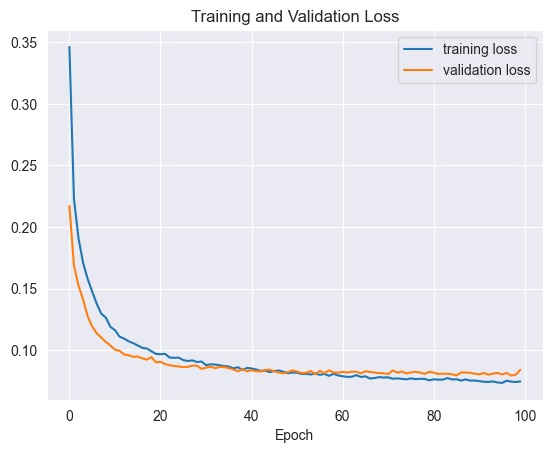

In [393]:
with open(f'../Models/Neural_Nets/training_losses_11.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_11.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The 'Training and Validation Loss' graph suggests slight overfitting is occurring after approximately 50 epochs.

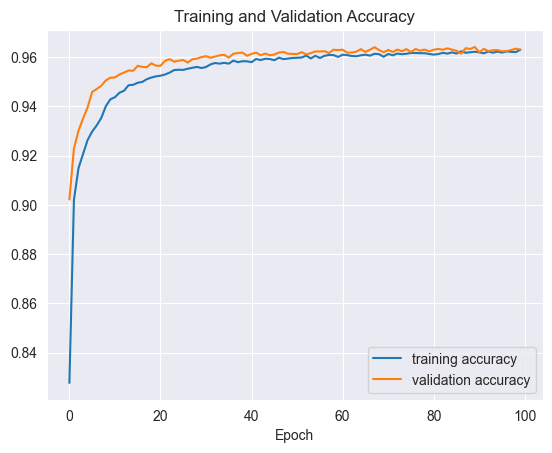

In [394]:
with open(f'../Models/Neural_Nets/train_accuracies_11.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_11.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The 'Training and Validation Accuracy' graph shows that the model performs quite well, without generalisation problems. 

Adjusting $\beta_1$ has slightly improved the model's performance. Although not presented here, adjusting $\beta_2$ did not improve the model's performance, so it has been left at default. 

Using the simple Sigmoid layer followed by the BCELoss criterion could cause model instability. This is why the criterion will be adjusted to BCEWithLogitsLoss (without a final Sigmoid layer). This loss combines a Sigmoid layer and BCELoss into a single class [(PyTorch Contributors, 2023)](#ref-pytorch2023).

In [171]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-4, betas=(0.8, 0.999))

In [172]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(12)

Epoch: 0 | Train Loss: 0.35335| Test loss: 0.22709
Epoch: 10 | Train Loss: 0.11641| Test loss: 0.10338
Epoch: 20 | Train Loss: 0.09867| Test loss: 0.09030
Epoch: 30 | Train Loss: 0.09125| Test loss: 0.08651
Epoch: 40 | Train Loss: 0.08641| Test loss: 0.08538
Epoch: 50 | Train Loss: 0.08252| Test loss: 0.08361
Epoch: 60 | Train Loss: 0.08098| Test loss: 0.08188
Epoch: 70 | Train Loss: 0.07865| Test loss: 0.08253
Epoch: 80 | Train Loss: 0.07662| Test loss: 0.08025
Epoch: 90 | Train Loss: 0.07604| Test loss: 0.08155

Best model saved with validation accuracy: 0.96599


Changing to the BCEWithLogitsLoss criterion has not improved model performance. However, it will be kept since numerical stability is important for predicting the final test set. The Adam optimiser will also be adjusted further. 

In [175]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4, betas=(0.8, 0.999))

In [176]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(13)

Epoch: 0 | Train Loss: 0.27976| Test loss: 0.17675
Epoch: 10 | Train Loss: 0.10068| Test loss: 0.09051
Epoch: 20 | Train Loss: 0.09100| Test loss: 0.08570
Epoch: 30 | Train Loss: 0.08808| Test loss: 0.08167
Epoch: 40 | Train Loss: 0.08649| Test loss: 0.08416
Epoch: 50 | Train Loss: 0.08567| Test loss: 0.08190
Epoch: 60 | Train Loss: 0.08319| Test loss: 0.08032
Epoch: 70 | Train Loss: 0.08226| Test loss: 0.08312
Epoch: 80 | Train Loss: 0.08272| Test loss: 0.08203
Epoch: 90 | Train Loss: 0.08225| Test loss: 0.08065

Best model saved with validation accuracy: 0.96638


Adjusting the Adam optimiser's learning rate improved the score. The next couple of models will require further adjustments.

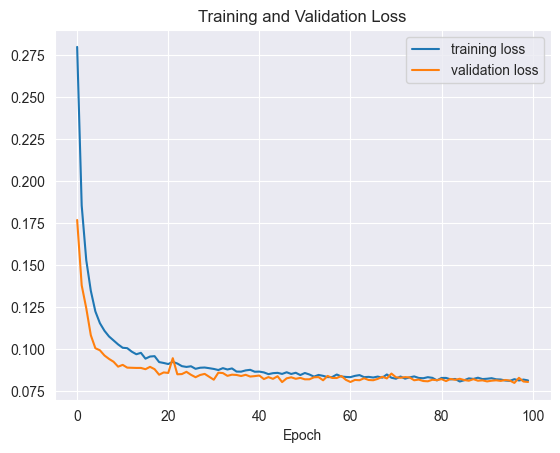

In [388]:
with open(f'../Models/Neural_Nets/training_losses_13.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_13.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The 'Training and Validation Loss' graph shows a well-performing model with no overfitting and a stable appearance.

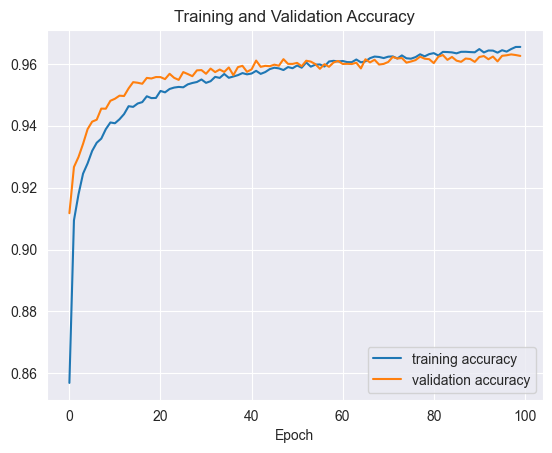

In [387]:
with open(f'../Models/Neural_Nets/train_accuracies_13.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_13.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The 'Training and Validation Accuracy' graph shows a relatively stable model, but there seems to be some overfitting after 60 epochs. Adjusting the Adam optimiser's learning rate has improved the model's performance. It will be adjusted further.

The learning rate is slightly lowered to 0.0025. 

In [182]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.0025, weight_decay=1e-4, betas=(0.8, 0.999))

In [183]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(14)

Epoch: 0 | Train Loss: 0.28446| Test loss: 0.17125
Epoch: 10 | Train Loss: 0.09946| Test loss: 0.08963
Epoch: 20 | Train Loss: 0.09025| Test loss: 0.08611
Epoch: 30 | Train Loss: 0.08700| Test loss: 0.08462
Epoch: 40 | Train Loss: 0.08552| Test loss: 0.08337
Epoch: 50 | Train Loss: 0.08239| Test loss: 0.08176
Epoch: 60 | Train Loss: 0.08253| Test loss: 0.08255
Epoch: 70 | Train Loss: 0.07996| Test loss: 0.08324
Epoch: 80 | Train Loss: 0.07994| Test loss: 0.08072
Epoch: 90 | Train Loss: 0.08039| Test loss: 0.08208

Best model saved with validation accuracy: 0.96686


Decreasing the learning has further improved the model.

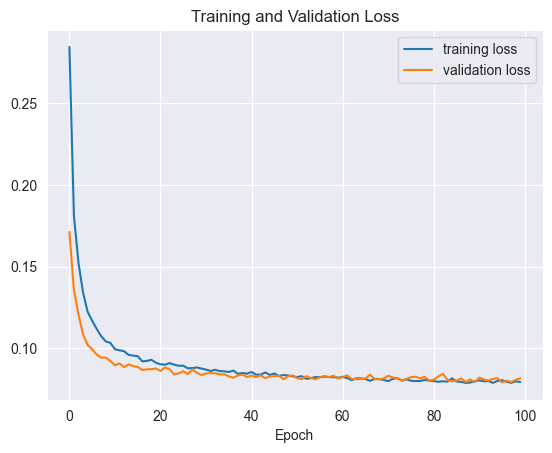

In [385]:
with open(f'../Models/Neural_Nets/training_losses_14.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_14.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

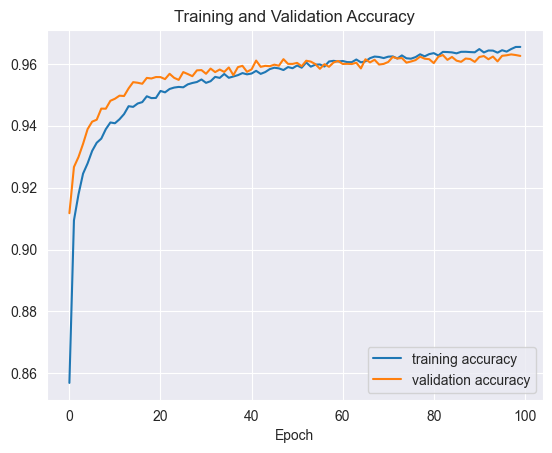

In [386]:
with open(f'../Models/Neural_Nets/train_accuracies_14.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_14.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The graphs show a similar model performance to that of the previous model. 

In the next model, the learning rate is lowered further to 0.002. 

In [184]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

In [185]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(15)

Epoch: 0 | Train Loss: 0.29875| Test loss: 0.18401
Epoch: 10 | Train Loss: 0.10268| Test loss: 0.09158
Epoch: 20 | Train Loss: 0.09136| Test loss: 0.08753
Epoch: 30 | Train Loss: 0.08738| Test loss: 0.08493
Epoch: 40 | Train Loss: 0.08536| Test loss: 0.08385
Epoch: 50 | Train Loss: 0.08386| Test loss: 0.08173
Epoch: 60 | Train Loss: 0.07994| Test loss: 0.08090
Epoch: 70 | Train Loss: 0.07963| Test loss: 0.08068
Epoch: 80 | Train Loss: 0.07881| Test loss: 0.07961
Epoch: 90 | Train Loss: 0.07827| Test loss: 0.08094

Best model saved with validation accuracy: 0.96704


Lowering the learning rate even more has continued to improve the accuracy score.

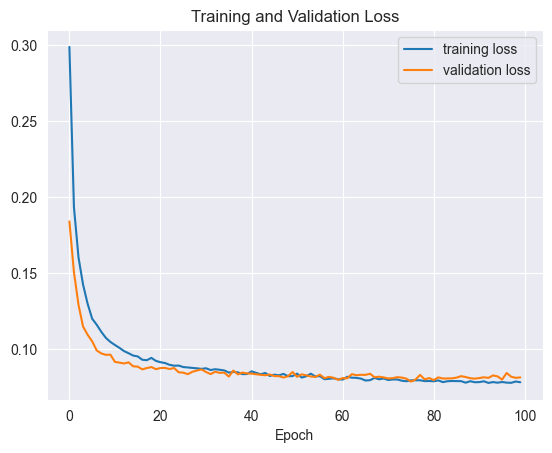

In [222]:
with open(f'../Models/Neural_Nets/training_losses_15.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_15.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The 'Training and Validation Loss' graph shows a good model performance. The training and validation loss is stable, and slight overfitting seems to occur after about 80 epochs. 

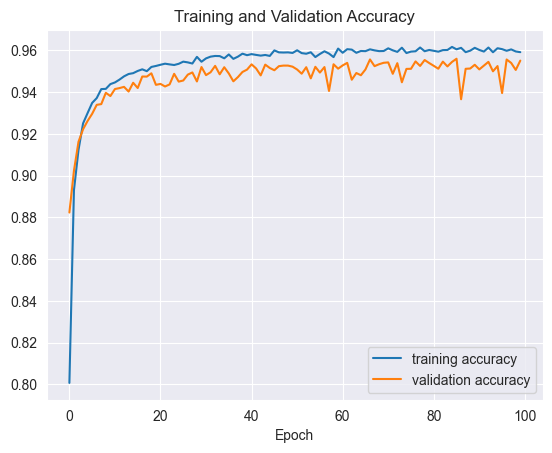

In [223]:
with open(f'../Models/Neural_Nets/train_accuracies_15.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_15.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The 'Training and Validation Accuracy' graph shows significant instability regarding validation accuracy. Although this model achieved the highest accuracy score, it is unreliable for predicting final test data.

Since model number 15's validation accuracy was substantially unstable, a dropout layer will be added to stabilise its performance. The dropout layer's probability is set to start at 0.2, increase to 0.35, and finish at 0.5.

In [315]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.2),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.35),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

In [316]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(16)

Epoch: 0 | Train Loss: 0.27605| Test loss: 0.16471
Epoch: 10 | Train Loss: 0.09575| Test loss: 0.09364
Epoch: 20 | Train Loss: 0.08386| Test loss: 0.08761
Epoch: 30 | Train Loss: 0.07951| Test loss: 0.08827
Epoch: 40 | Train Loss: 0.07775| Test loss: 0.08529
Epoch: 50 | Train Loss: 0.07414| Test loss: 0.08873
Epoch: 60 | Train Loss: 0.07405| Test loss: 0.08314
Epoch: 70 | Train Loss: 0.07104| Test loss: 0.08390
Epoch: 80 | Train Loss: 0.07007| Test loss: 0.08693
Epoch: 90 | Train Loss: 0.06953| Test loss: 0.08569

Best model saved with validation accuracy: 0.96595


The achieved accuracy score is relatively high.

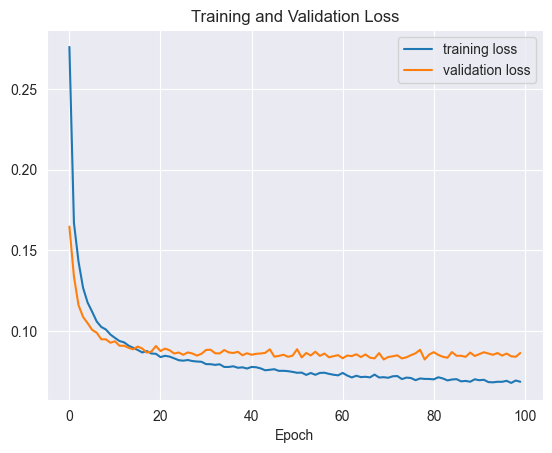

In [317]:
with open(f'../Models/Neural_Nets/training_losses_16.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_16.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

The 'Training and Validation Loss' graph shows model stability. After about 20 epochs, the model seems to be overfitting.

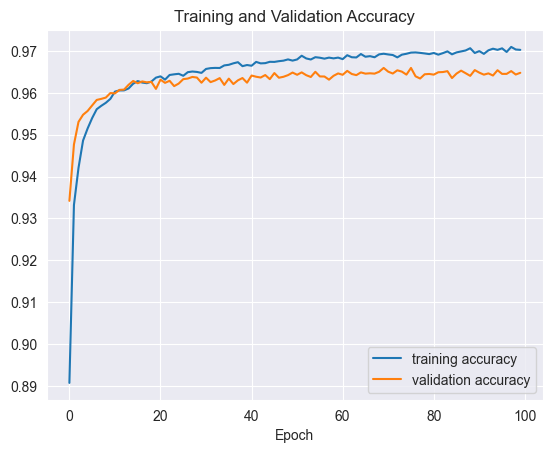

In [318]:
with open(f'../Models/Neural_Nets/train_accuracies_16.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_16.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Again, the 'Training and Validation Accuracy' graph shows good model performance. There seems to be some overfitting going on. The probability of the dropout layers will be adjusted further to improve the overfitting.

In [554]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.3),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.4),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

In [300]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(17)

Epoch: 0 | Train Loss: 0.28854| Test loss: 0.17399
Epoch: 10 | Train Loss: 0.09921| Test loss: 0.09173
Epoch: 20 | Train Loss: 0.08673| Test loss: 0.08603
Epoch: 30 | Train Loss: 0.08366| Test loss: 0.08304
Epoch: 40 | Train Loss: 0.08119| Test loss: 0.08389
Epoch: 50 | Train Loss: 0.07819| Test loss: 0.08261
Epoch: 60 | Train Loss: 0.07837| Test loss: 0.08262
Epoch: 70 | Train Loss: 0.07586| Test loss: 0.08473
Epoch: 80 | Train Loss: 0.07419| Test loss: 0.08346
Epoch: 90 | Train Loss: 0.07481| Test loss: 0.08412

Best model saved with validation accuracy: 0.96546


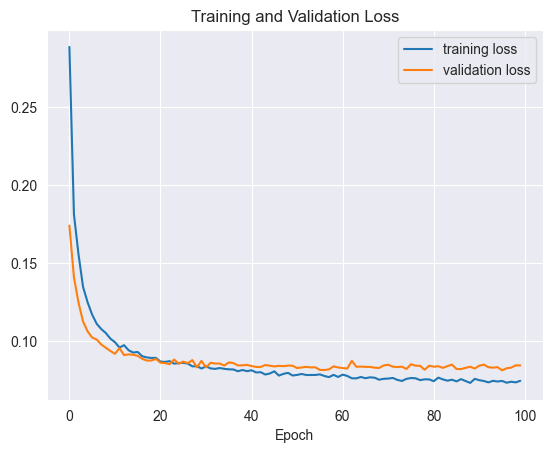

In [301]:
with open(f'../Models/Neural_Nets/training_losses_17.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_17.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

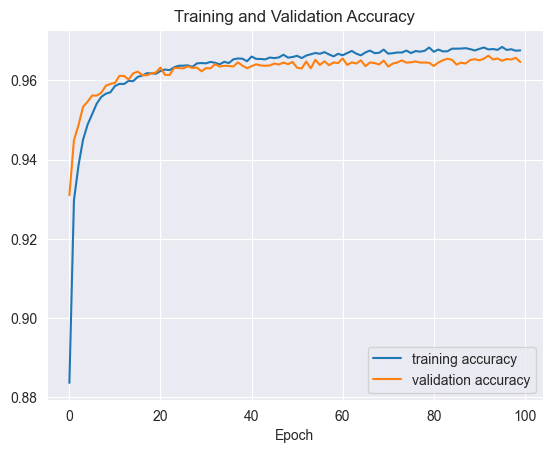

In [283]:
with open(f'../Models/Neural_Nets/train_accuracies_17.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_17.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Both graphs still show that overfitting is present.

In [302]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.3),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

In [303]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(18)

Epoch: 0 | Train Loss: 0.30604| Test loss: 0.18652
Epoch: 10 | Train Loss: 0.10802| Test loss: 0.09641
Epoch: 20 | Train Loss: 0.09632| Test loss: 0.09021
Epoch: 30 | Train Loss: 0.09092| Test loss: 0.08445
Epoch: 40 | Train Loss: 0.08825| Test loss: 0.08504
Epoch: 50 | Train Loss: 0.08667| Test loss: 0.08520
Epoch: 60 | Train Loss: 0.08626| Test loss: 0.08233
Epoch: 70 | Train Loss: 0.08534| Test loss: 0.08171
Epoch: 80 | Train Loss: 0.08324| Test loss: 0.08166
Epoch: 90 | Train Loss: 0.08287| Test loss: 0.08235

Best model saved with validation accuracy: 0.96564


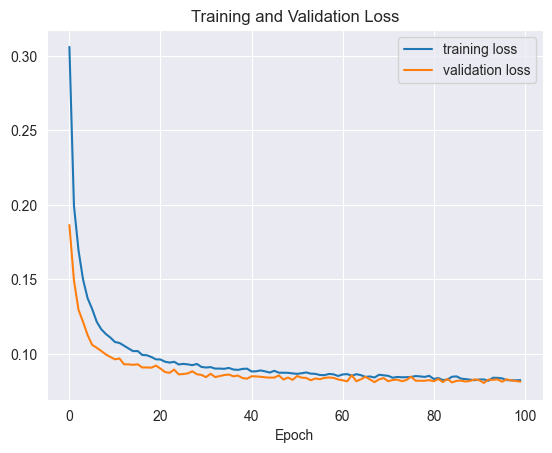

In [304]:
with open(f'../Models/Neural_Nets/training_losses_18.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_18.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

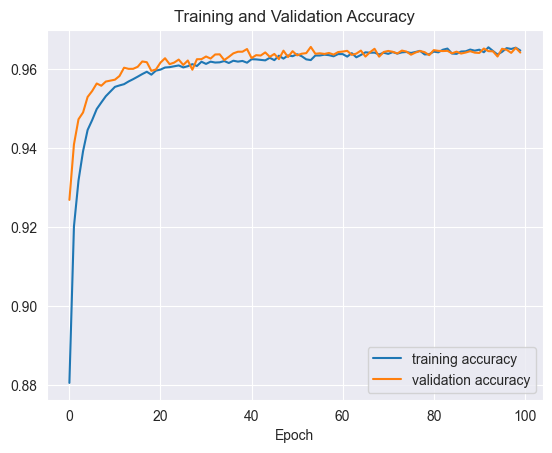

In [305]:
with open(f'../Models/Neural_Nets/train_accuracies_18.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_18.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Adjusting the dropout layer probabilities further has improved the problem and overfitting. It has also achieved a stable model performance with relatively high accuracy. The second dropout layer is also increased to 0.5 to see how the model will react.

In [555]:
# Defining the model
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

In [311]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(19)

Epoch: 0 | Train Loss: 0.31553| Test loss: 0.19013
Epoch: 10 | Train Loss: 0.11223| Test loss: 0.09866
Epoch: 20 | Train Loss: 0.09985| Test loss: 0.08759
Epoch: 30 | Train Loss: 0.09558| Test loss: 0.08617
Epoch: 40 | Train Loss: 0.09090| Test loss: 0.08341
Epoch: 50 | Train Loss: 0.09027| Test loss: 0.08292
Epoch: 60 | Train Loss: 0.08837| Test loss: 0.08452
Epoch: 70 | Train Loss: 0.08685| Test loss: 0.08425
Epoch: 80 | Train Loss: 0.08683| Test loss: 0.08291
Epoch: 90 | Train Loss: 0.08589| Test loss: 0.08289

Best model saved with validation accuracy: 0.96560


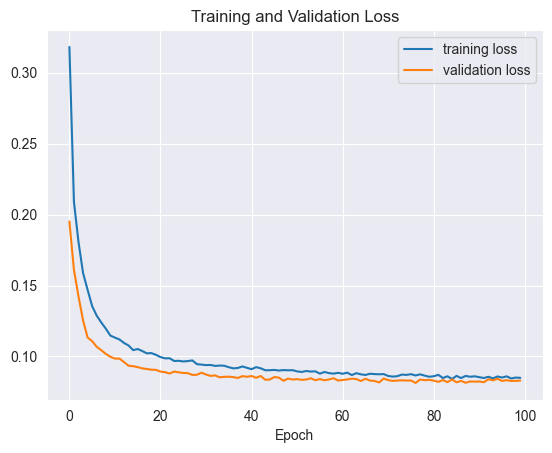

In [308]:
with open(f'../Models/Neural_Nets/training_losses_19.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_19.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

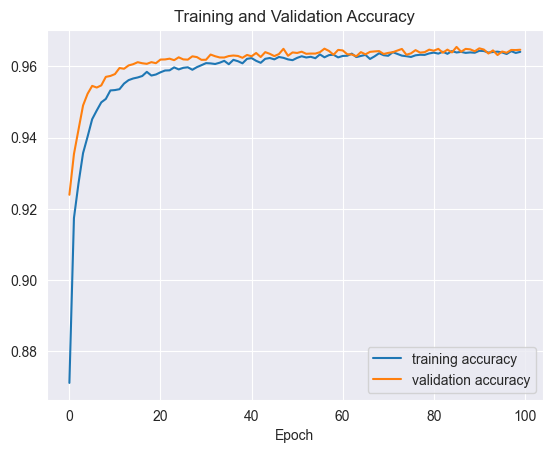

In [309]:
with open(f'../Models/Neural_Nets/train_accuracies_19.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_19.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Again, increasing all dropout layer probabilities to 0.5 has resulted in a good-performing model with no overfitting and a relatively high accuracy score.

## Deep Neural Network and Object-Oriented Programming

A simple neural network using PyTorch has achieved relatively high accuracy. However, object-oriented programming may provide further flexibility for improving the model. The following model will normalise the linear layers, and the He Kaiming method will ensure proper weight initialisation. The ReLU function will be replaced with ELU, which will help with vanishing gradients and dying neurons.

In [340]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 1)
        # Adding three batch normalisation layers:
        self.bn1 = nn.BatchNorm1d(300)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(100)
        # Adding 4 He Kaiming initialisation layers:
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        # Passing x through the second set of layers:
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        # Passing x through the third set of layers:
        x = self.fc3(x)
        x = self.bn3(x)
        x = nn.functional.elu(x)

        x = self.fc4(x)
        return x

net = Net()

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary', threshold=0.5)

A new function must be defined to run 100 epochs using the new model. 

In [341]:
def run_100_epochs_oop(number = 1):
    # Setting the number of epochs:
    epochs = 100

    # Instantiating metric results for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []

    # Instantiating the variables to track the best model based on validation accuracy:
    best_val_accuracy = 0.0  
    best_model_state = None 

    # Building the epoch loop:
    for epoch in range(epochs):
        
        # Setting the model to training mode:
        net.train()

        # Setting the training loss and accuracy to 0:
        training_loss = 0
        training_accuracy = 0
        metric.reset()

        # Building a loop for the train set data loader:
        for i, data in enumerate(trainloader, 0):
            # Setting the gradients to zero:
            optimizer.zero_grad()
            # Getting the feature and target from the data loader:
            feature, target = data
            # Runing the forward pass:
            prediction = net(feature)
            # Calculating the loss:
            loss = criterion(prediction, target)
            # Storing the loss values for plotting:
            training_loss += loss.item()
            # Calculating accuracy over the batch:
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            # Getting the gradients:
            loss.backward()
            # Updating the parameters:
            optimizer.step()

        # Storing the results of interest for plotting:
        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        # Setting the validation loss and accuracy to 0:
        validation_loss = 0
        validation_accuracy = 0

        # Setting the model to evaluation mode:
        net.eval()

        # Building a loop for the test set data loader:
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):

                # Starting an evaluation loop:
                net.eval()
                # Getting the feature and target from the data loader:
                feature, target = data
                # Running the forward pass:
                prediction = net(feature)
                # Calculating the loss:
                loss = criterion(prediction, target)
                # Calculating accuracy over the batch:
                accuracy = metric((prediction >= 0.5).float(), target)
                validation_accuracy += accuracy.item()
                validation_loss += loss.item()

        # Storing the results of interest for plotting:
        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        # Checking if this is the best model based on validation accuracy:
        if epoch_test_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_test_accuracy
            best_model_state = net.state_dict()

        # Setting the model back to training mode:
        net.train()

        # Printing out what's happening every ten epochs:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    # Saving the best model based on validation accuracy:
    if best_model_state:
        torch.save(best_model_state, ("../Models/Neural_Nets/best_model_{}.pth").format(number))
        print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.5f}")

    # Saving the lists using pickle:
    with open(f'../Models/Neural_Nets/training_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_loss_storage, file)
    with open(f'../Models/Neural_Nets/test_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_loss_storage, file)
    with open(f'../Models/Neural_Nets/train_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_accuracy_storage, file)
    with open(f'../Models/Neural_Nets/validation_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_accuracy_storage, file)

    return epoch_train_loss_storage, epoch_test_loss_storage, epoch_train_accuracy_storage, epoch_test_accuracy_storage

In [342]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs_oop(20)

Epoch: 0 | Train Loss: 0.22822| Test loss: 0.16650
Epoch: 10 | Train Loss: 0.10378| Test loss: 0.11407
Epoch: 20 | Train Loss: 0.09425| Test loss: 0.10752
Epoch: 30 | Train Loss: 0.09092| Test loss: 0.09477
Epoch: 40 | Train Loss: 0.08732| Test loss: 0.09535
Epoch: 50 | Train Loss: 0.08403| Test loss: 0.10030
Epoch: 60 | Train Loss: 0.08123| Test loss: 0.09571
Epoch: 70 | Train Loss: 0.07957| Test loss: 0.09552
Epoch: 80 | Train Loss: 0.07841| Test loss: 0.09601
Epoch: 90 | Train Loss: 0.07604| Test loss: 0.09148

Best model saved with validation accuracy: 0.96240


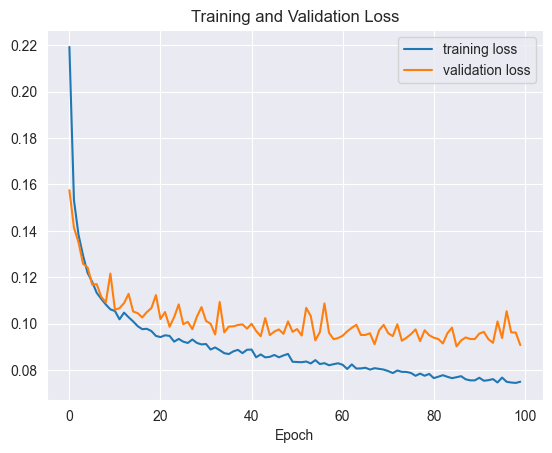

In [330]:
with open(f'../Models/Neural_Nets/training_losses_20.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_20.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

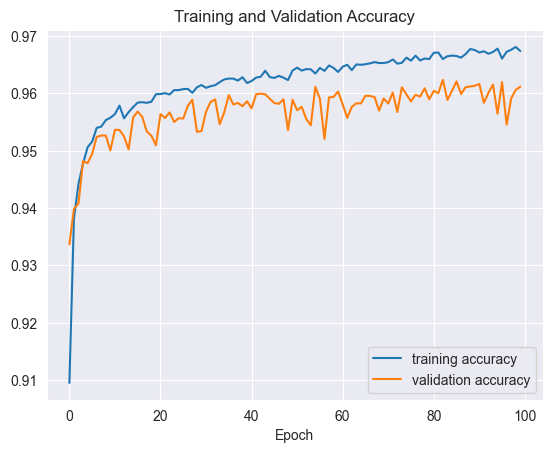

In [333]:
with open(f'../Models/Neural_Nets/train_accuracies_20.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_20.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The achieved accuracy score is quite high, but both graphs above show a model which does not generalise well to new data and has strong instability. Two batch normalisation layers will be removed to try to stabilise the model.

In [349]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 1)
        # Adding a batch normalisation layers:
        self.bn1 = nn.BatchNorm1d(300)
        # Adding three dropout layers:
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.5)
        # Adding 4 He Kaiming initialisation layers:
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.dropout1(x)

        # Passing x through the second set of layers:
        x = self.fc2(x)
        x = nn.functional.elu(x)
        x = self.dropout2(x)

        # Passing x through the third set of layers:
        x = self.fc3(x)
        x = nn.functional.elu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

net = Net()

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary', threshold=0.5)

In [350]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs_oop(21)

Epoch: 0 | Train Loss: 0.32970| Test loss: 0.19061
Epoch: 10 | Train Loss: 0.14563| Test loss: 0.11842
Epoch: 20 | Train Loss: 0.12462| Test loss: 0.10721
Epoch: 30 | Train Loss: 0.11589| Test loss: 0.09856
Epoch: 40 | Train Loss: 0.11325| Test loss: 0.09779
Epoch: 50 | Train Loss: 0.11165| Test loss: 0.09662
Epoch: 60 | Train Loss: 0.11070| Test loss: 0.09544
Epoch: 70 | Train Loss: 0.10930| Test loss: 0.09366
Epoch: 80 | Train Loss: 0.11053| Test loss: 0.09393
Epoch: 90 | Train Loss: 0.10950| Test loss: 0.09377

Best model saved with validation accuracy: 0.95960


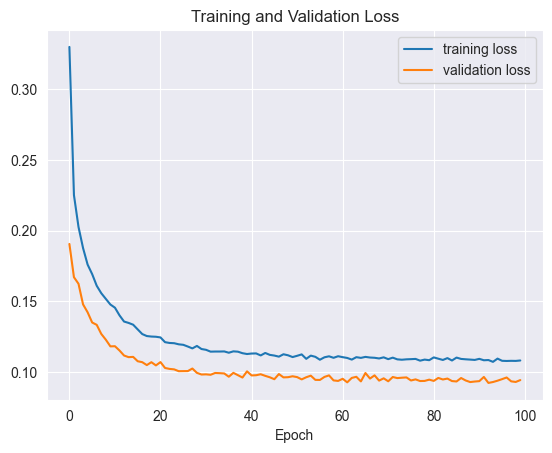

In [351]:
with open(f'../Models/Neural_Nets/training_losses_21.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_21.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

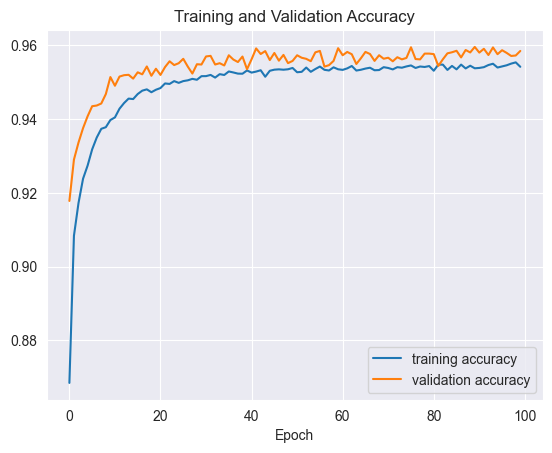

In [352]:
with open(f'../Models/Neural_Nets/train_accuracies_21.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_21.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The model's accuracy is not too bad; the two graphs above show that the model has largely stabilised. Further adjustments will be made by lowering the probabilities of the dropout layers. 

In [357]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 1)
        # Adding a batch normalisation layers:
        self.bn1 = nn.BatchNorm1d(300)
        # Adding three dropout layers:
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)
        # Adding 4 He Kaiming initialisation layers:
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.dropout1(x)

        # Passing x through the second set of layers:
        x = self.fc2(x)
        x = nn.functional.elu(x)
        x = self.dropout2(x)

        # Passing x through the third set of layers:
        x = self.fc3(x)
        x = nn.functional.elu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

net = Net()

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary', threshold=0.5)

In [358]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs_oop(22)

Epoch: 0 | Train Loss: 0.28926| Test loss: 0.17868
Epoch: 10 | Train Loss: 0.13265| Test loss: 0.11040
Epoch: 20 | Train Loss: 0.11522| Test loss: 0.10129
Epoch: 30 | Train Loss: 0.10714| Test loss: 0.09621
Epoch: 40 | Train Loss: 0.10563| Test loss: 0.09497
Epoch: 50 | Train Loss: 0.10374| Test loss: 0.09163
Epoch: 60 | Train Loss: 0.10341| Test loss: 0.09208
Epoch: 70 | Train Loss: 0.10232| Test loss: 0.09046
Epoch: 80 | Train Loss: 0.10223| Test loss: 0.09173
Epoch: 90 | Train Loss: 0.10212| Test loss: 0.09229

Best model saved with validation accuracy: 0.96114


Lowering the probabilities of the dropout layer has slightly improved the model's accuracy score. The probabilities will be lowered further in the next model.

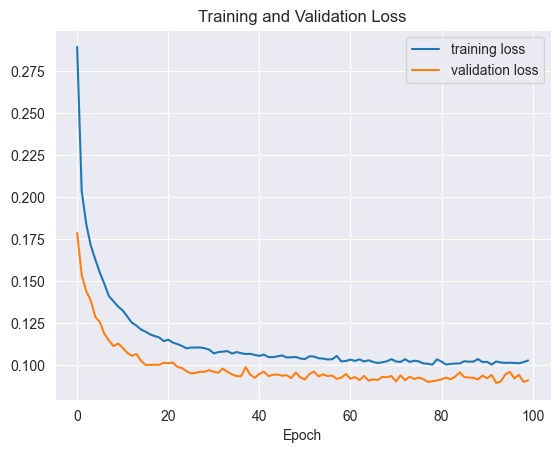

In [359]:
with open(f'../Models/Neural_Nets/training_losses_22.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_22.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

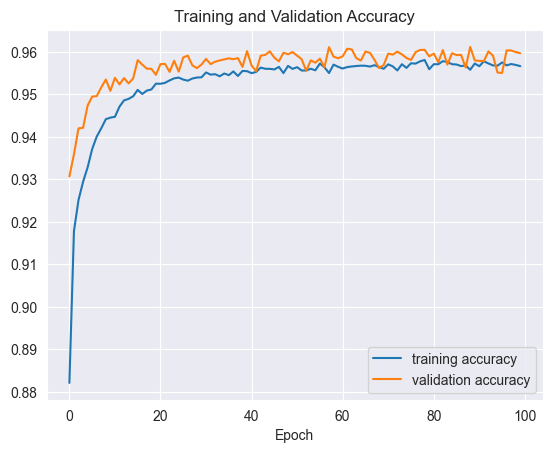

In [360]:
with open(f'../Models/Neural_Nets/train_accuracies_22.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_22.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Lowering the dropout layer probability has improved the accuracy score, but the accuracy graph remains significantly unstable. The dropout probability will be further lowered to 0.2.

In [361]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 1)
        # Adding a batch normalisation layers:
        self.bn1 = nn.BatchNorm1d(300)
        # Adding three dropout layers:
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        # Adding 4 He Kaiming initialisation layers:
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.dropout1(x)

        # Passing x through the second set of layers:
        x = self.fc2(x)
        x = nn.functional.elu(x)
        x = self.dropout2(x)

        # Passing x through the third set of layers:
        x = self.fc3(x)
        x = nn.functional.elu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

net = Net()

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary', threshold=0.5)

In [362]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs_oop(23)

Epoch: 0 | Train Loss: 0.25987| Test loss: 0.16492
Epoch: 10 | Train Loss: 0.11910| Test loss: 0.10389
Epoch: 20 | Train Loss: 0.10675| Test loss: 0.09757
Epoch: 30 | Train Loss: 0.10051| Test loss: 0.09316
Epoch: 40 | Train Loss: 0.09958| Test loss: 0.09235
Epoch: 50 | Train Loss: 0.09719| Test loss: 0.09157
Epoch: 60 | Train Loss: 0.09561| Test loss: 0.09195
Epoch: 70 | Train Loss: 0.09590| Test loss: 0.09057
Epoch: 80 | Train Loss: 0.09406| Test loss: 0.09000
Epoch: 90 | Train Loss: 0.09582| Test loss: 0.08753

Best model saved with validation accuracy: 0.96252


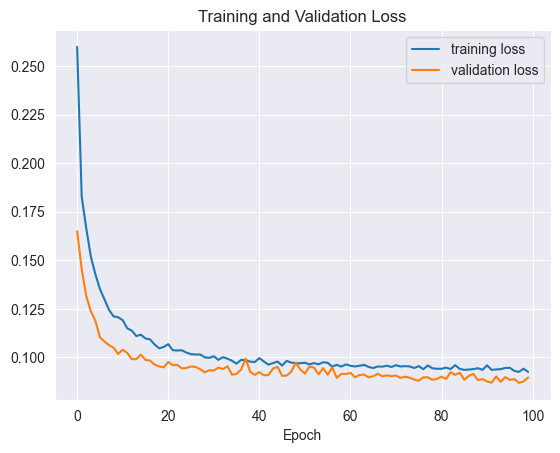

In [363]:
with open(f'../Models/Neural_Nets/training_losses_23.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_23.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

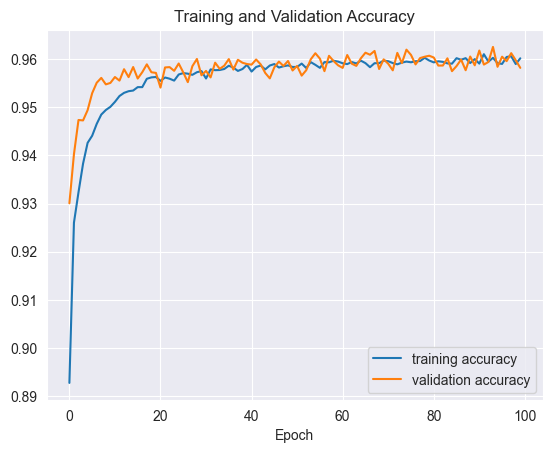

In [364]:
with open(f'../Models/Neural_Nets/train_accuracies_23.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_23.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Again, lowering the probabilities of the dropout layer has further improved the accuracy scores achieved. Now, the parameters of the linear layers will be increased.

In [374]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 400)
        self.fc2 = nn.Linear(400, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 1)
        # Adding a batch normalisation layers:
        self.bn1 = nn.BatchNorm1d(400)
        # Adding three dropout layers:
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        # Adding 4 He Kaiming initialisation layers:
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear") 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.dropout1(x)

        # Passing x through the second set of layers:
        x = self.fc2(x)
        x = nn.functional.elu(x)
        x = self.dropout2(x)

        # Passing x through the third set of layers:
        x = self.fc3(x)
        x = nn.functional.elu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

net = Net()

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Creating accuracy metric:
metric = torchmetrics.Accuracy(task = 'binary', threshold=0.5)

In [375]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs_oop(24)

Epoch: 0 | Train Loss: 0.24986| Test loss: 0.15861
Epoch: 10 | Train Loss: 0.11241| Test loss: 0.10015
Epoch: 20 | Train Loss: 0.10129| Test loss: 0.09343
Epoch: 30 | Train Loss: 0.09842| Test loss: 0.09133
Epoch: 40 | Train Loss: 0.09610| Test loss: 0.09062
Epoch: 50 | Train Loss: 0.09471| Test loss: 0.09391
Epoch: 60 | Train Loss: 0.09441| Test loss: 0.09059
Epoch: 70 | Train Loss: 0.09348| Test loss: 0.08771
Epoch: 80 | Train Loss: 0.09391| Test loss: 0.09109
Epoch: 90 | Train Loss: 0.09323| Test loss: 0.08809

Best model saved with validation accuracy: 0.96264


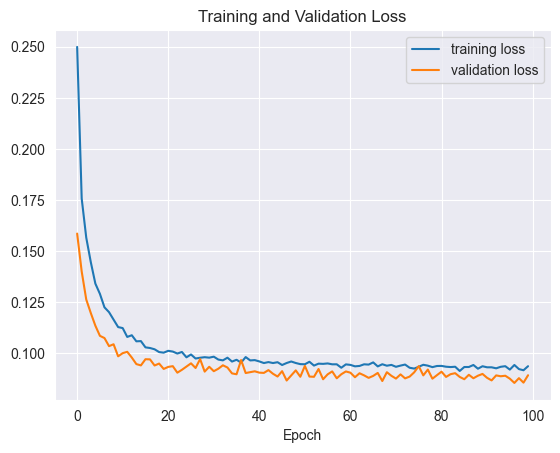

In [376]:
with open(f'../Models/Neural_Nets/training_losses_24.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_24.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

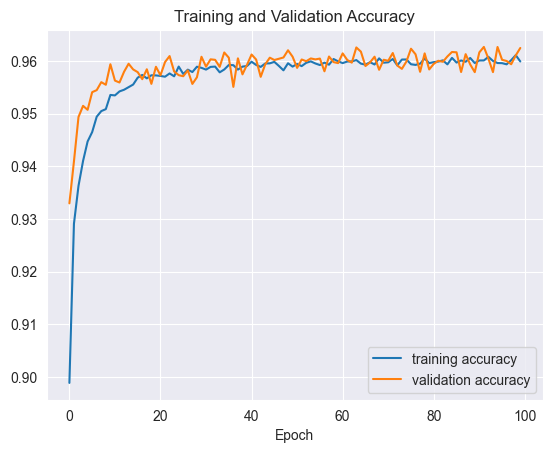

In [377]:
with open(f'../Models/Neural_Nets/train_accuracies_24.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_24.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The model's accuracy score is quite good, but some generalisation instability remains. A grid search will determine the best combination of learning rate, weight decay, and batch size. 

In [382]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(26, 400)
        self.fc2 = nn.Linear(400, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, 1)
        self.bn1 = nn.BatchNorm1d(400)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity="linear")

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = nn.functional.elu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = nn.functional.elu(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

def run_epochs(lr, weight_decay, epochs, batch_size, number=1):
    # Initialising model, criterion, and optimiser:
    net = Net()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.8, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    metric = torchmetrics.Accuracy(task='binary', threshold=0.5)
    
    # Data loaders (initialising trainloader and testloader with batch_size):
    train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train_encoded).reshape(-1, 1).float())
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = TensorDataset(torch.tensor(X_test_scaled).float(), torch.tensor(y_test_encoded).reshape(-1, 1).float())
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Tracking metrics for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(epochs):
        net.train()
        training_loss = 0
        training_accuracy = 0

        for feature, target in trainloader:
            optimizer.zero_grad()
            prediction = net(feature)
            loss = criterion(prediction, target)
            training_loss += loss.item()
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            loss.backward()
            optimizer.step()

        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        net.eval()
        validation_loss = 0
        validation_accuracy = 0
        with torch.no_grad():
            for feature, target in testloader:
                prediction = net(feature)
                loss = criterion(prediction, target)
                validation_loss += loss.item()
                accuracy = metric((prediction >= 0.5).float(), target)
                validation_accuracy += accuracy.item()

        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        if epoch_test_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_test_accuracy
            best_model_state = net.state_dict()

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    if best_model_state:
        torch.save(best_model_state, f"../Models/Neural_Nets/best_model_{number}.pth")
        print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.5f}")

    # Saving the lists using pickle:
    with open(f'../Models/Neural_Nets/training_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_loss_storage, file)
    with open(f'../Models/Neural_Nets/test_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_loss_storage, file)
    with open(f'../Models/Neural_Nets/train_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_accuracy_storage, file)
    with open(f'../Models/Neural_Nets/validation_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_accuracy_storage, file)

    return epoch_train_loss_storage, epoch_test_loss_storage, epoch_train_accuracy_storage, epoch_test_accuracy_storage, best_val_accuracy

# Defining the parameter grid:
param_grid = {
    'lr': [0.003, 0.0025, 0.002, 0.0015, 0.001],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'epochs': [100],
    'batch_size': [1000, 2000, 3000]
}

# Defining the grid search loop:
best_hyperparameters = None
highest_accuracy = 0

for idx, (lr, weight_decay, epochs, batch_size) in enumerate(itertools.product(
    param_grid['lr'], param_grid['weight_decay'], param_grid['epochs'], param_grid['batch_size']
), start=25):
    print(f"\nTesting combination {idx}: lr={lr}, weight_decay={weight_decay}, epochs={epochs}, batch_size={batch_size}")
    
    # Running the model with current parameters:
    train_losses, test_losses, train_accuracy, test_accuracy, val_accuracy = run_epochs(
        lr=lr, weight_decay=weight_decay, epochs=epochs, batch_size=batch_size, number=idx
    )

    # Tracking the best hyperparameters based on validation accuracy:
    if val_accuracy > highest_accuracy:
        highest_accuracy = val_accuracy
        best_hyperparameters = {
            'lr': lr,
            'weight_decay': weight_decay,
            'epochs': epochs,
            'batch_size': batch_size
        }

print("\nBest Hyperparameters:", best_hyperparameters)
print("Highest Validation Accuracy:", highest_accuracy)


Testing combination 25: lr=0.003, weight_decay=0.0001, epochs=100, batch_size=1000
Epoch: 0 | Train Loss: 0.23460| Test loss: 0.15354
Epoch: 10 | Train Loss: 0.10738| Test loss: 0.09832
Epoch: 20 | Train Loss: 0.10116| Test loss: 0.09596
Epoch: 30 | Train Loss: 0.09907| Test loss: 0.09384
Epoch: 40 | Train Loss: 0.10010| Test loss: 0.09658
Epoch: 50 | Train Loss: 0.09861| Test loss: 0.09251
Epoch: 60 | Train Loss: 0.09733| Test loss: 0.09000
Epoch: 70 | Train Loss: 0.09625| Test loss: 0.09096
Epoch: 80 | Train Loss: 0.09739| Test loss: 0.09295
Epoch: 90 | Train Loss: 0.09478| Test loss: 0.09202

Best model saved with validation accuracy: 0.96151

Testing combination 26: lr=0.003, weight_decay=0.0001, epochs=100, batch_size=2000
Epoch: 0 | Train Loss: 0.27980| Test loss: 0.16631
Epoch: 10 | Train Loss: 0.11460| Test loss: 0.11211
Epoch: 20 | Train Loss: 0.10296| Test loss: 0.09586
Epoch: 30 | Train Loss: 0.09952| Test loss: 0.09489
Epoch: 40 | Train Loss: 0.09556| Test loss: 0.09092
Ep

After the hyperparameter tuning, the object-oriented programming model achieved the best accuracy of 0.965, less than the best model number 15.

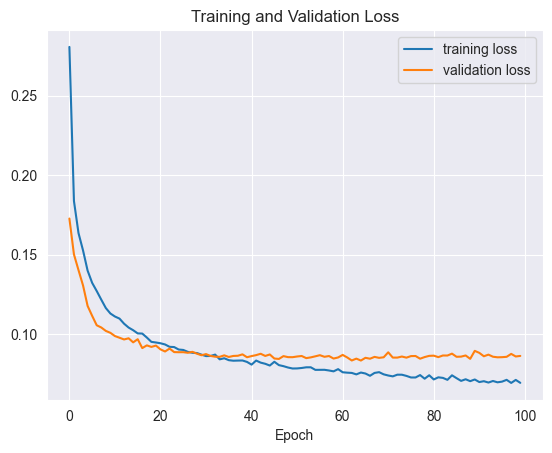

In [383]:
with open(f'../Models/Neural_Nets/training_losses_29.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_29.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

Although this model achieved the best score with the object-oriented model, the 'Training and Validation Loss' graph clearly shows that the model is overfitting. 

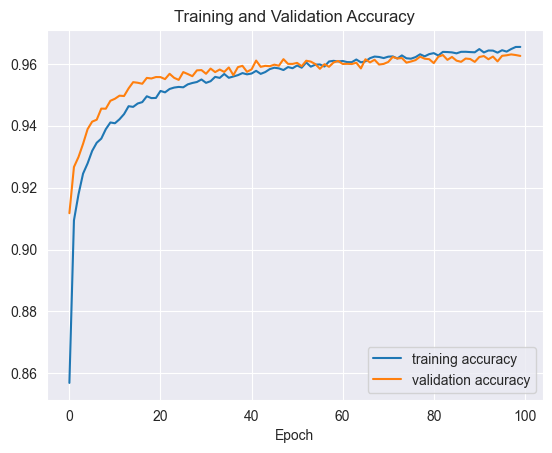

In [384]:
with open(f'../Models/Neural_Nets/train_accuracies_29.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_29.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

The 'Training and Validation Accuracy' graph shows that the model performs quite well in terms of accuracy; the model is overfitting after approximately 60 epochs.

## Preparation for Final Prediction

The deep neural network model 15 has the highest accuracy of 0.96704. However, the model showed strong signs of instability in validation accuracy. Although the model is promising, it is unreliable regarding new data generalisation. Below, a learning rate scheduler will be included to try stabilising the model's performance and allowing it to generalise better on new data. The step size is set to 15, and gamma is set to 0.5.

In [543]:
# Defining the model:
model = nn.Sequential(nn.Linear(26, 300),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(300, 200),
                      nn.ReLU(),
                      nn.Linear(200, 100),
                      nn.ReLU(),
                      nn.Dropout(p = 0.5),
                      nn.Linear(100, 1),
)

# Defining the criterion:
criterion = nn.BCEWithLogitsLoss()

# Defining the optimiser:
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-4, betas=(0.8, 0.999))

# Setting up scheduler:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

The epoch-running function must be adjusted to include the scheduler after each epoch. 

In [544]:
def run_100_epochs_scheduler(number = 1):
    # Setting the number of epochs:
    epochs = 100

    # Instantiating metric results for plotting:
    epoch_train_loss_storage = []
    epoch_test_loss_storage = []
    epoch_train_accuracy_storage = []
    epoch_test_accuracy_storage = []

    # Instantiation variables to track the best model based on validation accuracy:
    best_val_accuracy = 0.0 
    best_model_state = None

    # Building the epoch loop:
    for epoch in range(epochs):
        
        # Setting the model to training mode:
        model.train()

        # Setting the training loss and accuracy to 0:
        training_loss = 0
        training_accuracy = 0

        # Building a loop for the train set data loader:
        for i, data in enumerate(trainloader, 0):
            
            # Starting a training loop:
            model.train()
            # Setting the gradients to zero:
            optimizer.zero_grad()
            # Getting the feature and target from the data loader:
            feature, target = data
            # Runing the forward pass:
            prediction = model(feature)
            # Calculating the loss:
            loss = criterion(prediction, target)
            # Storing the loss values for plotting:
            training_loss += loss.item()
            # Calculating accuracy over the batch:
            accuracy = metric(prediction, target)
            training_accuracy += accuracy.item()
            # Getting the gradients:
            loss.backward()
            # Updating the parameters:
            optimizer.step()

        # Storing the results of interest for plotting:
        epoch_train_loss = training_loss / len(trainloader)
        epoch_train_loss_storage.append(epoch_train_loss)
        epoch_train_accuracy = training_accuracy / len(trainloader)
        epoch_train_accuracy_storage.append(epoch_train_accuracy)

        # Setting the validation loss and accuracy to 0:
        validation_loss = 0
        validation_accuracy = 0

        # Setting the model to evaluation mode:
        model.eval()

        # Building a loop for the test set data loader:
        with torch.no_grad():
            for i, data in enumerate(testloader, 0):

                # Starting an evaluation loop:
                model.eval()
                # Getting the feature and target from the data loader:
                feature, target = data
                # Running the forward pass:
                prediction = model(feature)
                # Calculating the loss:
                loss = criterion(prediction, target)
                # Calculating accuracy over batch:
                accuracy = metric(prediction, target)
                validation_accuracy += accuracy.item()
                validation_loss += loss.item()
                # Step the scheduler at the end of each epoch
                scheduler.step()

        # Storing the results of interest for plotting:
        epoch_test_loss = validation_loss / len(testloader)
        epoch_test_loss_storage.append(epoch_test_loss)
        epoch_test_accuracy = validation_accuracy / len(testloader)
        epoch_test_accuracy_storage.append(epoch_test_accuracy)

        # Check if this is the best model based on validation accuracy (or loss):
        if epoch_test_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_test_accuracy
            best_model_state = model.state_dict()

        # Setting the model back to training mode:
        model.train()

        # Printing out what's happening every ten epochs:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {epoch_train_loss:.5f}| Test loss: {epoch_test_loss:.5f}")

    # Saving the best model based on validation accuracy:
    if best_model_state:
        torch.save(best_model_state, ("../Models/Neural_Nets/best_model_{}.pth").format(number))
        print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.5f}")

    # Resetting the metrics:
    metric.reset() 

    # Saving the lists using pickle:
    with open(f'../Models/Neural_Nets/training_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_loss_storage, file)
    with open(f'../Models/Neural_Nets/test_losses_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_loss_storage, file)
    with open(f'../Models/Neural_Nets/train_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_train_accuracy_storage, file)
    with open(f'../Models/Neural_Nets/validation_accuracies_{number}.pkl', 'wb') as file:
        pickle.dump(epoch_test_accuracy_storage, file)

    return epoch_train_loss_storage, epoch_test_loss_storage, epoch_train_accuracy_storage, epoch_test_accuracy_storage

In [545]:
train_losses, test_losses, train_accuracy, test_accuracy = run_100_epochs(70)

Epoch: 0 | Train Loss: 0.30200| Test loss: 0.17882
Epoch: 10 | Train Loss: 0.10369| Test loss: 0.09238
Epoch: 20 | Train Loss: 0.09203| Test loss: 0.08624
Epoch: 30 | Train Loss: 0.08702| Test loss: 0.08408
Epoch: 40 | Train Loss: 0.08363| Test loss: 0.08102
Epoch: 50 | Train Loss: 0.08171| Test loss: 0.07994
Epoch: 60 | Train Loss: 0.08057| Test loss: 0.08160
Epoch: 70 | Train Loss: 0.08062| Test loss: 0.07968
Epoch: 80 | Train Loss: 0.07930| Test loss: 0.07921
Epoch: 90 | Train Loss: 0.07797| Test loss: 0.07819

Best model saved with validation accuracy: 0.96733


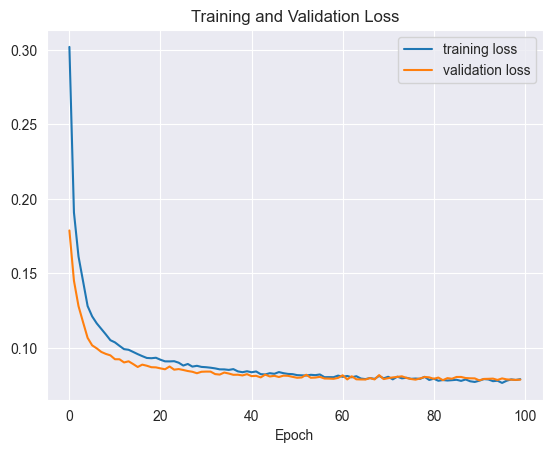

In [546]:
with open(f'../Models/Neural_Nets/training_losses_70.pkl', 'rb') as file:
       train_losses = pickle.load(file)
with open(f'../Models/Neural_Nets/test_losses_70.pkl', 'rb') as file:
       test_losses = pickle.load(file)

plot_loss(train_losses, test_losses)

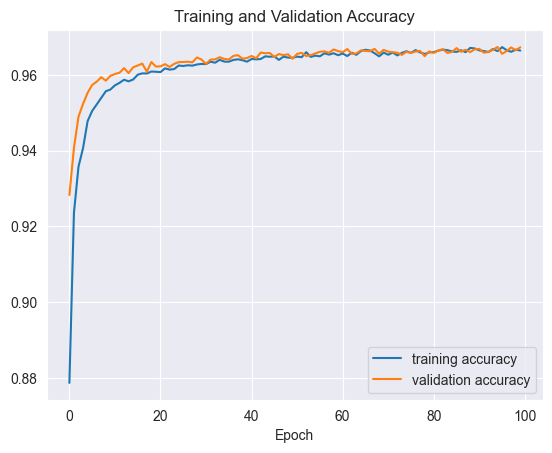

In [547]:
with open(f'../Models/Neural_Nets/train_accuracies_70.pkl', 'rb') as file:
       train_accuracies = pickle.load(file)
with open(f'../Models/Neural_Nets/validation_accuracies_70.pkl', 'rb') as file:
       test_accuracies = pickle.load(file)

plot_accuracy(train_accuracy, test_accuracy)

Adding a learning scheduler has allowed the model to achieve the best accuracy of this project of 0.96733. The loss and accuracy scores above show that the model can be relied upon to perform well on new data. This is the model that will be used on the final test set.

## Final Predictions

The final test data set will be imported and processed further. The last model will predict customer satisfaction on the test set. An accuracy score and confusion matrix will show how the model performs on new data. 

In [548]:
# Importing the preprocessed data set:
test = pd.read_pickle('../Data/Preprocessed/test_preprocessed.pkl')

test.shape

(25976, 27)

In [549]:
# Splitting the data into features and responses:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [510]:
# Splitting the data into features and response:
X = test.drop(columns = 'Satisfaction', axis = 1)
y = test['Satisfaction']

# Scaling the data:
X_scaled = scaler.transform(X)

# Encoding the target:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# Creating the test_dataset and the validation loader:
test_dataset = TensorDataset(torch.tensor(X_scaled).float(), torch.tensor(y_encoded).reshape(-1, 1).float())
testloader = DataLoader(test_dataset, batch_size = 1000, shuffle = True)

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_21771/1244191997.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../Models/N

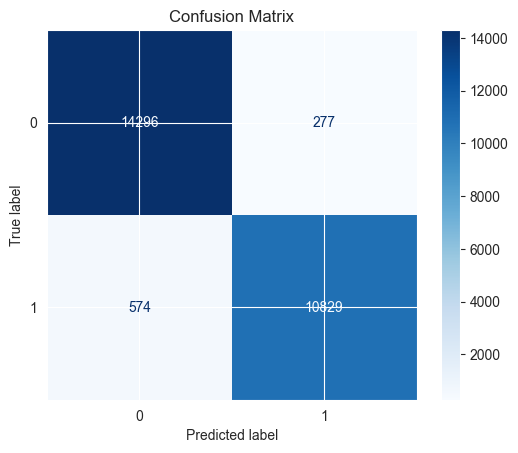

Test Accuracy: 0.96724


In [550]:
# Loading the saved model state dictionary:
model.load_state_dict(torch.load("../Models/Neural_Nets/best_model_70.pth"))
model.eval()

# Instantiating containers for all predictions and true labels:
all_predictions = []
all_true_labels = []

# Performing the evaluation loop over the test set:
with torch.no_grad():
    for features, targets in testloader:
        outputs = model(features)
        probabilities = torch.sigmoid(outputs)
        predicted_labels = (probabilities >= 0.5).float()
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(targets.cpu().numpy())

# Converting the collected predictions and true labels to numpy arrays:
all_predictions = np.array(all_predictions).reshape(-1)
all_true_labels = np.array(all_true_labels).reshape(-1)

# Saving predictions to CSV:
prediction_df = pd.DataFrame(all_predictions, columns=["Predictions"])
prediction_df.to_csv("../Data/Predictions/prediction.csv", index=False)

# Making a confusion matrix:
cm = confusion_matrix(all_true_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Calculating the final accuracy:
final_accuracy = (all_predictions == all_true_labels).mean()
print("Test Accuracy:", round(final_accuracy, 5))

The final accuracy score on the test dataset is 0.96724, slightly lower than that on the validation set of the final model. The confusion matrix above shows that the model performs very well in classifying customer satisfaction. 

## References

1. <a id="ref-Geron2023"></a>Aurelian Géron, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd Edition), O'Reilly Media Inc, 20 January 2023.

2. <a id="ref-pytorch2023"></a>PyTorch Contributors, BCEWithLogitsLoss, Pytorch, 2023, [(link)](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

3. <a id='ref-pytorch2023'></a>Pytorch Contributors, SGD, Pytorch, 2023, [(link)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).